In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [ ]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [ ]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer_1 = nn.Linear(
            in_features=kwargs["input_shape"], out_features=256
        )
        self.encoder_hidden_layer_2 = nn.Linear(
            in_features=256, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=32
        )
        #Here, we have a latent representation of 32 features
        self.decoder_hidden_layer_1 = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_hidden_layer_2 = nn.Linear(
            in_features=128, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["input_shape"]
        )

    def forward(self, features, return_encoding=False):
        #when return encoding is True,
        #forward will return both the reconstructed data and the latent encoding
        encoded = self.encoder_hidden_layer_1(features)
        encoded  = torch.relu(encoded)
        encoded = self.encoder_hidden_layer_2(encoded)
        encoded  = torch.relu(encoded)
        encoded  = self.encoder_output_layer(encoded)
        encoded = torch.relu(encoded)
        decoded = self.decoder_hidden_layer_1(encoded)
        decoded = torch.relu(decoded)
        decoded = self.decoder_hidden_layer_2(decoded)
        decoded = torch.relu(decoded)
        decoded = self.decoder_output_layer(decoded)
        reconstructed = torch.relu(decoded)
        if return_encoding:
            return reconstructed, encoded
        return reconstructed

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(input_shape=X_train.shape[1]).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss() #comparing decoded image to encoded image

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()

# create a TensorDataset from the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [ ]:
epochs=10
l1_param = 0.0001 #how strongly to enforce l1 regularization - play around with this

for epoch in range(epochs):
    loss = 0
    l1_loss = 0
    for batch_features, _ in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions and encoded
        outputs, encoded = model(batch_features, return_encoding=True)

        # apply penalty to all non-zero encoded values
        # https://debuggercafe.com/sparse-autoencoders-using-l1-regularization-with-pytorch/
        l1_regularization = l1_param * torch.mean(torch.abs(encoded))
        l1_loss += l1_regularization
        # compute training reconstruction loss + l1_regularization
        train_loss = criterion(outputs, batch_features) + l1_regularization

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(train_loader)

    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    #display l1 loss
    print("loss from l1:", l1_loss/len(train_loader))

epoch : 1/10, loss = 1.015211
loss from l1: tensor(6.4468e-06, grad_fn=<DivBackward0>)
epoch : 2/10, loss = 1.007028
loss from l1: tensor(1.4389e-05, grad_fn=<DivBackward0>)
epoch : 3/10, loss = 0.991135
loss from l1: tensor(3.3061e-05, grad_fn=<DivBackward0>)
epoch : 4/10, loss = 0.988891
loss from l1: tensor(5.6554e-05, grad_fn=<DivBackward0>)
epoch : 5/10, loss = 0.962914
loss from l1: tensor(8.3747e-05, grad_fn=<DivBackward0>)
epoch : 6/10, loss = 0.948901
loss from l1: tensor(0.0001, grad_fn=<DivBackward0>)
epoch : 7/10, loss = 0.929560
loss from l1: tensor(0.0001, grad_fn=<DivBackward0>)
epoch : 8/10, loss = 0.936579
loss from l1: tensor(0.0001, grad_fn=<DivBackward0>)
epoch : 9/10, loss = 0.922612
loss from l1: tensor(0.0002, grad_fn=<DivBackward0>)
epoch : 10/10, loss = 0.929446
loss from l1: tensor(0.0002, grad_fn=<DivBackward0>)


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

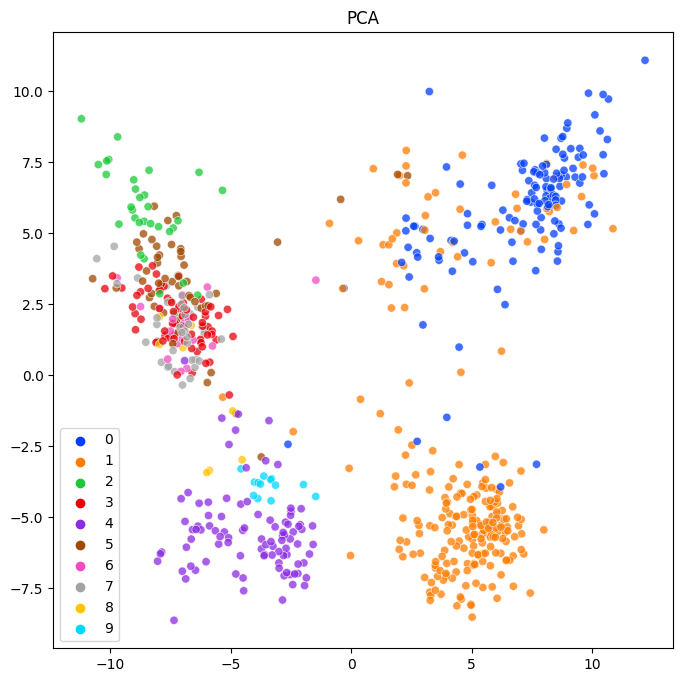

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
y = y.argmax(axis=1)

# Plot PCA
plt.figure(figsize=(8,8))
sns.scatterplot(
    x = X_pca[:,0], y= X_pca[:,1],
    hue=y,
    palette="bright",
    legend="full",
    alpha=0.75)
plt.title('PCA')
plt.show()

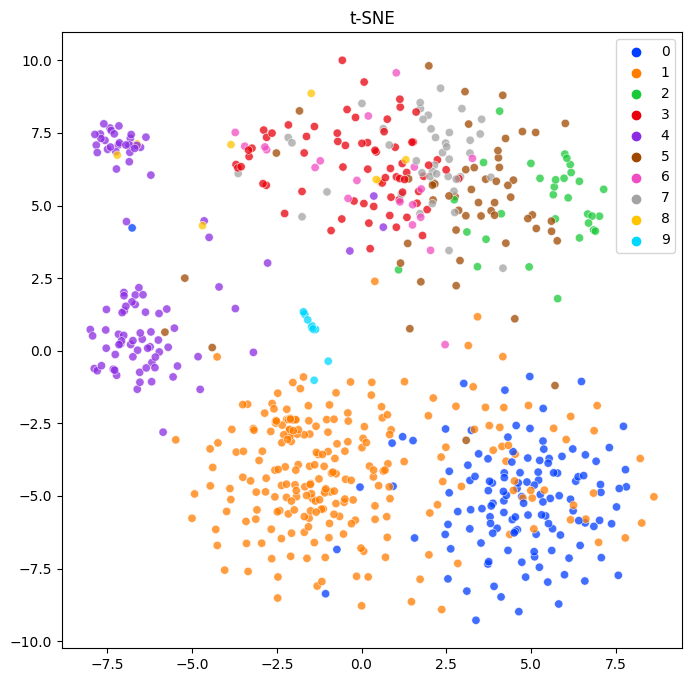

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette="bright",
    legend="full",
    alpha=0.75
)
plt.title('t-SNE')
plt.show()

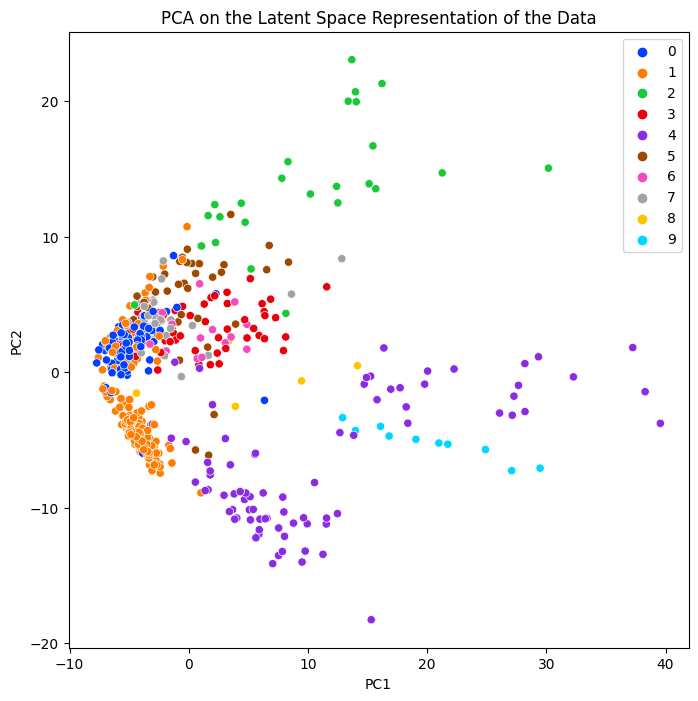

In [ ]:
# perform PCA on the latent space representation
# extract the latent space representation of the data
with torch.no_grad():
    X_train_encoded = model(torch.tensor(X_train).float().to(device), return_encoding=True)[1].cpu().numpy()
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_encoded)

# plot the PCA on the latent space representation
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x=X_train_pca[:, 0], y=X_train_pca[:, 1],
    hue=np.argmax(y_train, axis=1),
    palette="bright",
    ax=ax)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA on the Latent Space Representation of the Data")
plt.show()

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.